In [ ]:
import os 

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160,160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [ 
        os.path.join(input_dir,fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

target_img_paths = sorted(
    [ 
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples ", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10],target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples  7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


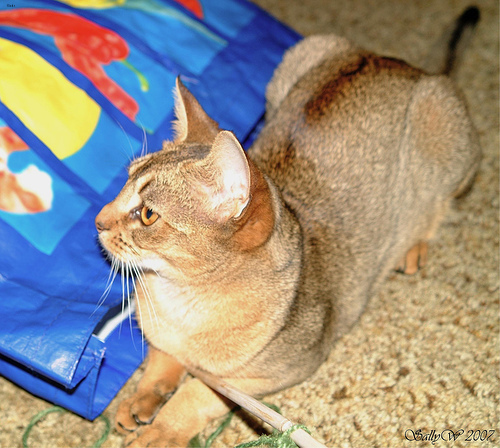

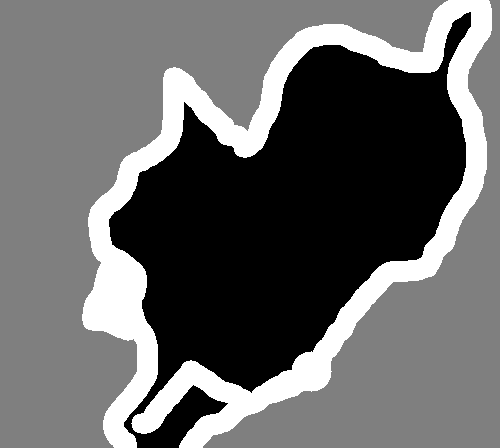

In [2]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL 
from PIL import ImageOps

display(Image(filename=input_img_paths[9]))

img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [3]:
from tensorflow import keras
import numpy as np 
from tensorflow.keras.preprocessing.image import load_img

class OxfordPets(keras.utils.Sequence):
    def __init__(self,batch_size,img_size,input_img_paths,target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths)//self.batch_size
    
    def __getitem__(self,idx):

        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype= "uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path,target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img,2)
            y[j] -= 1
        
        return x,y

In [4]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size +(3,))

    x = layers.Conv2D(32,3,strides=2,padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for filters in [64, 128, 258]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x,residual])
        previous_block_activation = x

    for filters in [256,128,64,32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding= "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)


    model = keras.Model(inputs, outputs)
    return model

keras.backend.clear_session()

model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
import random

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [6]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxfordpets_segmentation.h5", save_best_only=True)
]

epochs = 15

model.fit(train_gen, epochs = epochs, validation_data = val_gen, callbacks= callbacks)


Epoch 1/15
199/199 [==============================] - 62s 272ms/step - loss: 1.1176 - val_loss: 1.1653
Epoch 2/15


C:\Users\anike\.conda\envs\tf-venv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


199/199 [==============================] - 43s 214ms/step - loss: 0.5094 - val_loss: 2.1440
Epoch 3/15
199/199 [==============================] - 43s 215ms/step - loss: 0.4278 - val_loss: 0.4574
Epoch 4/15
199/199 [==============================] - 43s 217ms/step - loss: 0.3831 - val_loss: 0.4351
Epoch 5/15
199/199 [==============================] - 42s 212ms/step - loss: 0.3494 - val_loss: 0.4034
Epoch 6/15
199/199 [==============================] - 43s 213ms/step - loss: 0.3215 - val_loss: 0.3688
Epoch 7/15
199/199 [==============================] - 43s 215ms/step - loss: 0.2955 - val_loss: 0.4382
Epoch 8/15
199/199 [==============================] - 43s 216ms/step - loss: 0.2734 - val_loss: 0.3807
Epoch 9/15
199/199 [==============================] - 43s 214ms/step - loss: 0.2549 - val_loss: 0.3608
Epoch 10/15
199/199 [==============================] - 36s 179ms/step - loss: 0.2380 - val_loss: 0.3577
Epoch 11/15
199/199 [==============================] - 36s 179ms/step - loss: 0.222

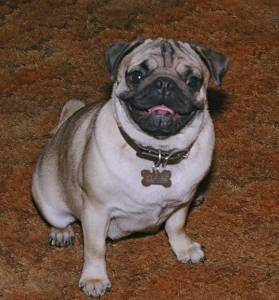

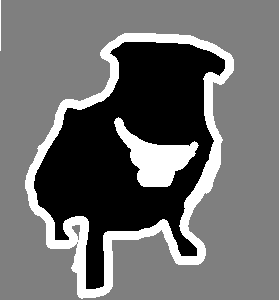

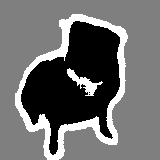

In [8]:
val_gen = OxfordPets(batch_size ,img_size, val_input_img_paths, val_target_img_paths)

val_preds = model.predict(val_gen)

def display_mask(i):
    mask = np.argmax(val_preds[i],axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


i = 10

display(Image(filename=val_input_img_paths[i]))

img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

display_mask(i)

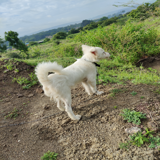

In [10]:
img = PIL.Image.open('roxy.jpg')
img = img.resize((160,160))
display(img)

In [11]:
def display_mask(i):
    mask = np.argmax(val_preds[i],axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

ValueError: Failed to find data adapter that can handle input: <class 'PIL.Image.Image'>, <class 'NoneType'>